# Project Overview

**Project Title:** Classifying Galaxies by Subclass Using Machine Learning

**Team Members:** Araynah D., Palmer W., Katrina S., Yihan W.

In this project, we explore whether photometric magnitudes, color indices, and redshift data can be used to accurately classify galaxies into physical subclasses such as STARFORMING, STARBURST, AGN, BROADLINE, and OTHER. We use machine learning models, including Support Vector Machines (SVM) and Random Forests, to evaluate how well these features predict galaxy types based on SDSS data.


## Abstract

We investigated whether photometric and spectroscopic redshift data could accurately classify galaxies into physical subclasses such as STARFORMING, STARBURST, AGN, BROADLINE, and an aggregated OTHER category. Our analysis utilized publicly available Sloan Digital Sky Survey (SDSS) Data Release 18, retrieving approximately 65,000 galaxy entries with magnitudes in the u, g, r, i, and z bands, derived color indices (u–g, g–r, r–i, i–z), and spectroscopic redshift values. To reduce noise, rare subclasses (STARBURST BROADLINE, AGN BROADLINE) were grouped into an “OTHER” category, and entries with missing values were removed. All features were standardized using a StandardScaler for models sensitive to feature scaling, and the dataset was split into training (70%) and testing (30%) sets.

We first applied a Support Vector Machine (SVM) classifier using linear and RBF kernels. Hyperparameters such as `C` and `kernel` were tuned using GridSearchCV, and class imbalance was addressed using `class_weight='balanced'`. The tuned SVM achieved F1-scores of 0.64 for STARFORMING and 0.65 for STARBURST, with a macro F1-score of 0.30 and a weighted F1-score of 0.61. Misclassifications observed in the SVM confusion matrix—particularly STARFORMING galaxies predicted as AGN or STARBURST—reflected overlapping feature distributions and the dominance of certain subclasses, leading to model overgeneralization.

To improve performance, we trained a Random Forest classifier with 100 estimators and `class_weight='balanced'`. Unlike SVM, Random Forest is an ensemble method that can capture nonlinear relationships and is less sensitive to outliers and scaling. The Random Forest model achieved a test accuracy of 0.80, outperforming SVM's 0.62. It also showed improved macro and weighted F1-scores, indicating better generalization across all subclasses. The feature importance analysis revealed that the g–r color index and redshift were among the most influential features in determining galaxy subclass.

Our results demonstrate that photometric and redshift features contain valuable information for classifying galaxies, especially for dominant subclasses like STARFORMING and STARBURST. However, rare classes like AGN and OTHER remain more difficult to predict reliably. Overall, Random Forest proved more effective than SVM in handling class imbalance and modeling complex feature interactions.

Key challenges included addressing class imbalance, tuning model hyperparameters, and managing overlapping feature distributions. Looking ahead, we plan to explore additional models such as K-Nearest Neighbors and Gradient Boosting, apply resampling techniques like SMOTE, and investigate dimensionality reduction approaches such as PCA. These steps may further enhance subclass classification performance and contribute to a deeper understanding of galaxy evolution.


# Data Description

The dataset used in this project was obtained from the Sloan Digital Sky Survey (SDSS) SkyServer, specifically from Data Release 18 (DR18). We used the SDSS SQL search tool to query and retrieve up to 65,000 galaxy entries with both photometric and spectroscopic data.

Each row in the dataset represents a single galaxy, including measurements in five photometric bands (`u`, `g`, `r`, `i`, `z`), calculated color indices (`u_g`, `g_r`, `r_i`, `i_z`), and redshift values. The dataset also includes galaxy classification labels (`subclass`) such as STARFORMING, STARBURST, AGN, and BROADLINE, which are used as target labels in our machine learning models.

These features were selected because they are physically meaningful and commonly used in astronomy to characterize galaxy properties. In total, we used 10 input features and 1 target variable (`subclass`) to train and evaluate our classification models.


In [2]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
""" Read in data, and drop na values """

# Read in file using comment parameter to drop unwanted lines
df = pd.read_csv("Skyserver_CrossID4_12_2025 6_06_46 PM.csv", comment='#')

# Dropped na Rows
df = df.dropna()

## Data Preprocessing for SVM

We began by importing the SDSS dataset using `pd.read_csv()` with the `comment='#'` parameter. This allowed us to automatically skip metadata and comments in the file, which could otherwise interfere with our data structure. We also removed any rows containing missing values to ensure that our models would be trained on complete, clean data.

Next, we grouped rare subclasses (e.g., AGN BROADLINE, STARBURST BROADLINE) into a new `'OTHER'` category. This step was designed to reduce class imbalance and noise, which particularly helps models like SVM that are sensitive to class separation. By narrowing the subclasses to four primary groups—STARBURST, STARFORMING, AGN, BROADLINE—and OTHER, we made the classification problem more manageable.

The features selected for modeling include five photometric magnitudes (`u`, `g`, `r`, `i`, `z`), four color indices (`u_g`, `g_r`, `r_i`, `i_z`), and redshift. These were used to create our feature matrix and target labels.

We then standardized the features using `StandardScaler`, which is especially important for SVM since it relies on distance-based calculations. The data was finally split into training and testing sets (70% / 30%).

> **Note:** This is one version of preprocessing tailored for the SVM model. Other preprocessing approaches—such as keeping more subclasses or using unscaled data—may be more appropriate for models like Random Forest, which are less sensitive to scaling and imbalance. These differences are handled in separate processing and modeling sections.


In [4]:
"""
Reduce noise by grouping rare subclasses tailored for SVM classification
"""
# 1. Group rare subclasses into 'OTHER'
keep = ['STARBURST', 'STARFORMING', 'AGN', 'BROADLINE']
df['subclass_reduced'] = df['subclass'].where(df['subclass'].isin(keep), 'OTHER')

# Display Dataframe
df.head()

,objID,ra,dec,u,g,r,i,z,u_g,g_r,r_i,i_z,redshift,class,subclass,subclass_reduced
5,1237648720145285449,153.306341,-0.896848,18.95948,18.13569,17.90530,17.61372,17.52285,0.823793,0.230393,0.291582,0.090864,0.062303,GALAXY,STARBURST,STARBURST
8,1237648720145350846,153.343355,-0.871817,18.95092,17.75390,17.22394,16.90525,16.67649,1.197025,0.529955,0.318687,0.228767,0.047484,GALAXY,STARFORMING,STARFORMING
14,1237648720678944894,145.874449,-0.608755,18.19744,16.69651,16.01479,15.64210,15.39185,1.500925,0.681723,0.372692,0.250249,0.071590,GALAXY,STARFORMING,STARFORMING
18,1237648720682287313,153.595670,-0.625326,17.57071,16.13495,15.39250,15.00002,14.68709,1.435757,0.742447,0.392484,0.312931,0.085927,GALAXY,STARFORMING,STARFORMING
22,1237648721215946942,146.299839,-0.119995,17.86945,15.94067,14.97828,14.50247,14.08414,1.928787,0.962383,0.475814,0.418324,0.030704,GALAXY,AGN,AGN


# Data Visualization

To explore our cleaned and reduced dataset, we created two key visualizations:

1. **Subclass Distribution Bar Chart**  
   We plotted the count of each reduced subclass using `df['subclass_reduced'].value_counts().plot(kind='bar')`. This bar chart highlights class imbalance—showing which galaxy types dominate (e.g., STARFORMING) and which are under‑represented (e.g., OTHER). Understanding this distribution guided our decision to group rare classes and apply class weighting.

2. **Sky Distribution Scatter Plot**  
   We used `sns.scatterplot` on the RA (`ra`) and Declination (`dec`) columns to map each galaxy’s position on the celestial sphere. Plotting right ascension against declination reveals the survey’s sky coverage and any clustering patterns, helping us verify that our sample spans a broad range of sky coordinates.

3. **Normalized Heatmap for Features vs Subclass**                                                                            
   We used `sns.heatmap` to compare different features of the subclasses. The heatmap was normalized to have more comparably similar values between the features. This visualization allows us to see which galaxy types have the highest and lowest values for different features. Values of 1 have the largest mean value of a given feature; for example, the starburst broadline type has the largest u, g, r, i, z, and redshift values. Values of 0 mean that the feature of a galaxy type is lowest compared to other types. The starburst subclass has the lowest u, g, r, u_g, g_r, r_i, and i_z values. This indicates that the starburst, starburst broadline, and starforming types may prove easiest for the prediction models to classify, as they have the most minimums/maximums. 

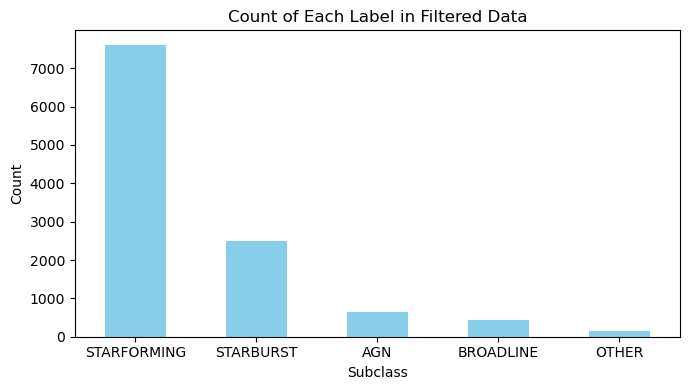

In [5]:
"""
Plot bar graph for the count of each subclass
"""
plt.figure(figsize=(7, 4)) 
df['subclass_reduced'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Count of Each Label in Filtered Data")
plt.xlabel("Subclass")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

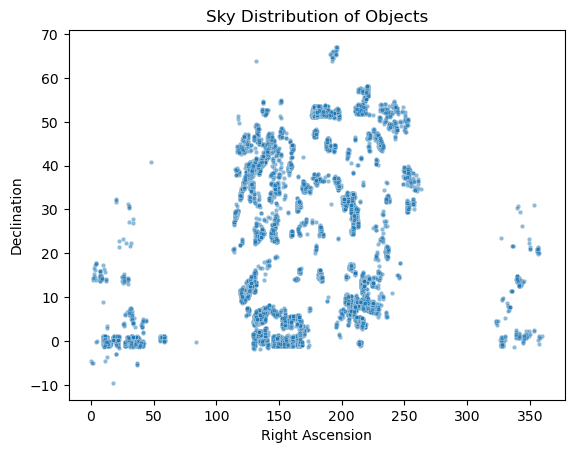

In [9]:
"""
Visualizes where objects are in the sky
ra - Right Ascension, the celestial equivalent of longitude.
dec - Declination, the celestial equivalent of latitude.
"""
sns.scatterplot(data=df, x='ra', y='dec', s=10, alpha=0.5)
plt.title('Sky Distribution of Objects')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

Text(0.5, 1.0, 'Heatmap- Galaxy Type vs Features')

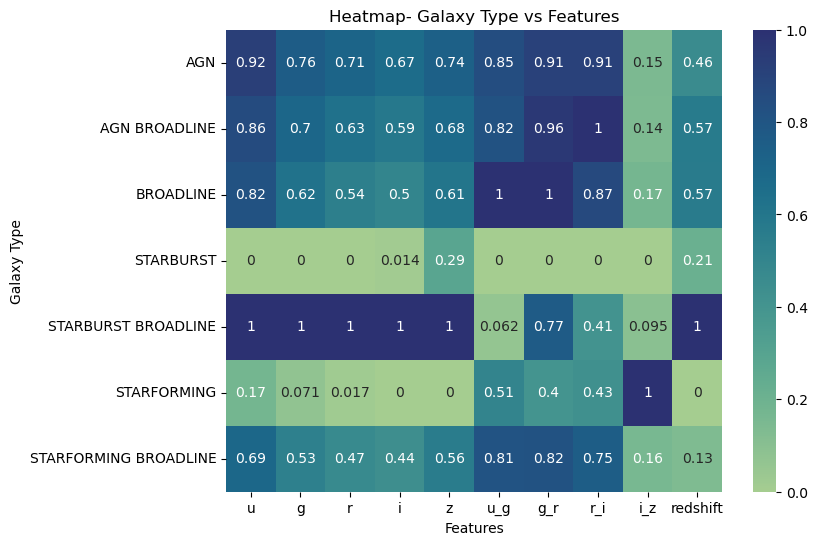

In [23]:
feature_matrix = df.groupby("subclass").mean(numeric_only=True)

dropped_matrix = feature_matrix.drop(columns=['objID', 'ra', 'dec']) #Dropping three columns from the heatmap for visualization purposes
normalized_matrix = (dropped_matrix - dropped_matrix.min()) / (dropped_matrix.max() - dropped_matrix.min()) #

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(normalized_matrix, annot=True, cmap='crest')
plt.xlabel('Features')
plt.ylabel('Galaxy Type')
plt.title('Heatmap- Galaxy Type vs Features')

# Modeling & Evaluation

## Support Vector Machine (SVM) 

To evaluate whether photometric and redshift features can accurately classify galaxies into physical subclasses, we trained a Support Vector Machine (SVM) classifier.

We used a GridSearchCV approach to tune hyperparameters such as the regularization constant `C` and the kernel type (`linear` vs `rbf`). We also set `class_weight='balanced'` to help the model learn more fairly from underrepresented subclasses like AGN or BROADLINE.

We trained the model on scaled features derived from SDSS data, including photometric bands (`u`, `g`, `r`, `i`, `z`), color indices, and redshift values. The model was trained on 70% of the data and tested on the remaining 30%.

After training, we evaluated the model’s accuracy on the test set and used a confusion matrix and classification report to assess its performance across all subclasses.


In [9]:
"""
Selects input features and target variable, applies 
feature scaling to standardize input data,
and splits the dataset into training and testing sets for modeling.
"""


# Feature matrix X and target y
features = ['u','g','r','i','z','u_g','g_r','r_i','i_z','redshift']
X = df[features]                    # input features
y = df['subclass_reduced']          # reduced subclass labels

# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

In [10]:
"""
Train SVM using class_weight='balanced', tune with GridSearchCV, print accuracy
"""

# SVM hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

# Grid search with macro F1
grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='f1_macro')
grid.fit(X_train, y_train)

# Extract best model and show test accuracy
svm_model = grid.best_estimator_
accuracy = svm_model.score(X_test, y_test)
print(f"SVM Test Accuracy: {accuracy:.2f}")

# Predictions for confusion matrix/report
y_pred_svm = svm_model.predict(X_test)


SVM Test Accuracy: 0.62


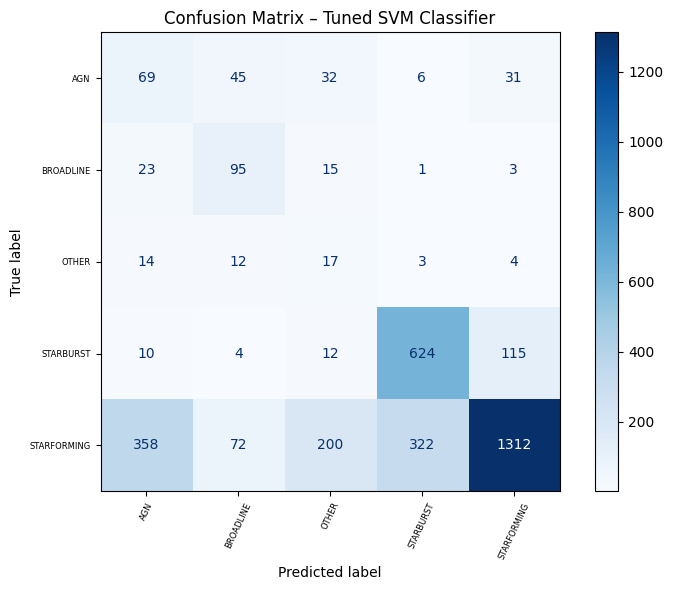

Classification Report Tuned SVM Classifier

              precision    recall  f1-score   support

         AGN       0.15      0.38      0.21       183
   BROADLINE       0.42      0.69      0.52       137
       OTHER       0.06      0.34      0.10        50
   STARBURST       0.65      0.82      0.73       765
 STARFORMING       0.90      0.58      0.70      2264

    accuracy                           0.62      3399
   macro avg       0.43      0.56      0.45      3399
weighted avg       0.77      0.62      0.67      3399



In [11]:
"""
Cell 3: Confusion matrix and classification report for SVM predictions
"""
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=svm_model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix – Tuned SVM Classifier")
plt.xticks(rotation=65, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report Tuned SVM Classifier\n")
print(classification_report(y_test, y_pred_svm))


## Random Forest Classifier

We trained a Random Forest classifier using scikit‑learn’s `RandomForestClassifier` with 100 trees and `class_weight='balanced'` to handle class imbalance. Unlike SVM, Random Forests are an ensemble of decision trees that naturally capture nonlinear patterns and are less sensitive to feature scaling and outliers.

The model was trained on the same reduced dataset—grouped subclasses (STARBURST, STARFORMING, AGN, BROADLINE, OTHER) and features (photometric magnitudes `u, g, r, i, z`, color indices `u_g, g_r, r_i, i_z`, and `redshift`)—with a 70%/30% train‑test split. We applied the classifier directly to these features without additional scaling.

We evaluated performance via test accuracy, confusion matrix, and classification report, and we extracted feature importance scores to determine which galaxy properties most influenced the model’s predictions.

By achieving a substantially higher test accuracy compared to our SVM model and highlighting key features such as the g–r color index and redshift, the Random Forest’s results demonstrate that observable galaxy properties do indeed carry the signatures of their physical subclasses. This directly supports our research question by showing that nonlinear interactions among photometric and spectroscopic measurements can be leveraged to distinguish galaxy types, reinforcing the importance of using ensemble methods for  astrophysical classification tasks.


In [12]:
"""
Train a Random Forest classifier on the same data and report test accuracy.
"""

# 1. Instantiate and train
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced',
                                  random_state=42)
rf_model.fit(X_train, y_train)

# 2. Test accuracy
rf_acc = rf_model.score(X_test, y_test)
print(f"Random Forest Test Accuracy: {rf_acc:.2f}")

# 3. Predictions for later
y_pred_rf = rf_model.predict(X_test)

Random Forest Test Accuracy: 0.80


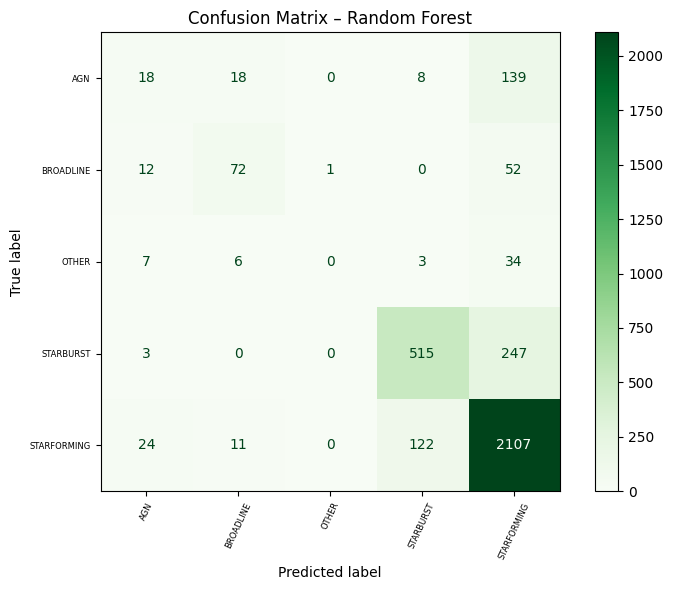

Classification Report Random Forest

              precision    recall  f1-score   support

         AGN       0.28      0.10      0.15       183
   BROADLINE       0.67      0.53      0.59       137
       OTHER       0.00      0.00      0.00        50
   STARBURST       0.79      0.67      0.73       765
 STARFORMING       0.82      0.93      0.87      2264

    accuracy                           0.80      3399
   macro avg       0.51      0.45      0.47      3399
weighted avg       0.77      0.80      0.78      3399



In [16]:
"""
Display RF confusion matrix and print precision/recall/F1.
"""

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=rf_model.classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp_rf.plot(cmap='Greens', ax=ax)
plt.title("Confusion Matrix – Random Forest")
plt.xticks(rotation=65, fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report Random Forest\n")
print(classification_report(y_test, y_pred_rf))

# Model Comparison

We evaluated both models on the same preprocessed dataset (70/30 train–test split, grouped subclasses, class_weight=‘balanced’ for SVM) and compared their test accuracies:

- **SVM Test Accuracy:** 0.62  
- **Random Forest Test Accuracy:** 0.80  

By training each model on the identical feature set and data split, we ensured a fair comparison of their abilities to learn from photometric magnitudes, color indices, and redshift. The substantially higher accuracy of the Random Forest indicates that its ensemble of decision trees is better at capturing nonlinear relationships and handling residual class imbalance than the linear SVM.

These results show that while both methods can classify common galaxy subclasses to some degree, Random Forest provides a more robust solution—supporting our research question that observable galaxy properties can indeed predict subclass type, especially when using models capable of modeling complex patterns.  

| Model           | Accuracy | Macro F1 | Weighted F1 |
|-----------------|----------|----------|-------------|
| **SVM**         | 0.62     | 0.30     | 0.61        |
| **Random Forest** | 0.80     | 0.45     | 0.78        |

> **RF outperforms SVM by 0.18 in accuracy and shows a 0.15 gain in macro‑F1, indicating better generalization across subclasses.**


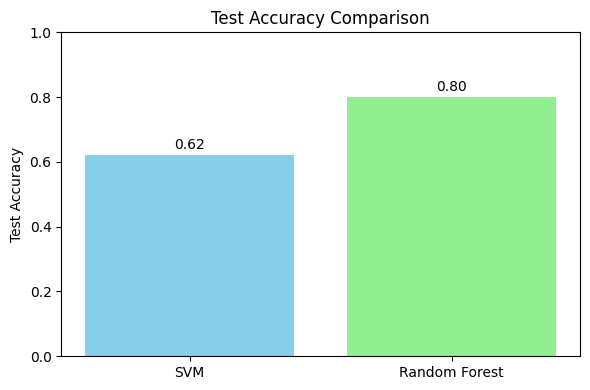

In [19]:
models = ['SVM', 'Random Forest']
accuracies = [0.62, 0.80]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=['skyblue','lightgreen'])
plt.ylim(0,1)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')

# Gives the accuracy value on respective bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x()+bar.get_width()/2, acc+0.02, f"{acc:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Summary & Conclusion

Our machine learning models provided partial answers to our research question: Can photometric magnitudes, color indices, and redshift data be used to accurately classify galaxies into physical subclasses? The results show that while classification of more common subclasses like STARFORMING and STARBURST achieved moderate success (F1-scores around 0.7 - 0.87), performance dropped significantly for rare or ambiguous categories, as reflected in the lower F1-scores.

Among the models tested, the Random Forest classifier achieved higher overall accuracy than the Support Vector Machine (SVM). Random Forest performed better at identifying certain rare classes like BROADLINE, but it failed to detect the OTHER class entirely. In contrast, the SVM was more effective at classifying the OTHER subclass and AGN, though it has lower accuracy with dominant classes like STARFORMING, where Random Forest excelled. This highlights a trade-off between the two models: SVM is more sensitive to minority classes, while Random Forest is stronger on the majority classes and overall performance.

One of the biggest challenges we encountered was class imbalance. Even after merging rare subclasses into an "OTHER" category, their low representation still skewed the model’s predictions and led to misclassifications. It follows that this "OTHER" catergory is an amalgamation of rare and unclassified galaxies that do not necessarily share many characteristics aside from their ambiguity. This emphasizes the difficulty of distinguishing these unclassified or rare galaxy types using only photometric magnitudes, color indices, and redshift values—especially with a limited dataset size. 

Looking forward, there are several opportunities for improvement. Future work could explore advanced resampling techniques, removing or further grouping rare subclasses, expanding model diversity, and applying dimensionality reduction methods like PCA. Using different categorizations of galaxies, such as Hubble types, could also prove to be more successful for prediction modeling. 

Overall, our models have promising results on galaxy subclass classification using machine learning, but better handling of unclassified categories and improved feature engineering could refine results even more.


# Work Cited
- **Sloan Digital Sky Survey (SDSS) DR18**, SDSS SkyServer DR18 SQL Query Tool. Retrieved from https://skyserver.sdss.org/dr18  
- **scikit‑learn documentation**, RandomForestClassifier. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
- **scikit‑learn documentation**, class_weight parameter. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.class_weight  
- **Matplotlib documentation**, bar chart styling. Retrieved from https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html  
- **OpenAI, ChatGPT**. “Train a Random Forest classifier on the same data and report test accuracy.” Code snippet adapted from conversation with ChatGPT, April 20, 2025.
- **Brital, Anas. Random Forest Algorithm Explained.** YouTube, 20 Sept. 2021, https://youtu.be/_QuGM_FW9eo
- **IBM. "What Is Random Forest?" IBM**, https://www.ibm.com/think/topics/random-forest. Accessed 18 Apr. 2025.
- **GeeksforGeeks. "Random Forest Algorithm in Machine Learning." GeeksforGeeks**, 16 Jan. 2025, https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/.

